<a href="https://colab.research.google.com/github/melodyyu1112/Machine_learning_416/blob/master/A2_Ridge_and_LASSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Ridge and LASSO Regression

### Due: Tuesday, July 9th, 11:59 pm on Gradescope.

In this assignment we'll look at the affect of using regularization on linear regression models that we train. Write code to train models that use different regularizers and different penalties and to analyze how this affects the model.


> Copyright ©2019 Emily Fox and Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Summer Quarter 2019 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [0]:
# This cell is necessary only if you are running on Google Colab

import requests

def save_file(url, file_name):
  r = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(r.content)

save_file('https://homes.cs.washington.edu/~hschafer/cse416/a2/home_data.csv',
          'home_data.csv')

In [0]:
# Conventionally people rename these common imports for brevity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Magic command to make the plots appear in-line (it's actually called a "magic command")
%matplotlib inline

For this assignment, we will only be using a very small subset of the data to do our analysis. This is not something you would usually do in practice, but is something we do for this assignment to simplify this complexity of this dataset. The data is pretty noisy and to get meaningful results to demonstrate the theoretical behavior, you would need to use a much more complicated set of features that would be a bit more tedious to work with.

In [0]:
sales = pd.read_csv('home_data.csv') 

# Selects 1% of the data
sales = sales.sample(frac=0.01, random_state=0) 

print(f'Number of points: {len(sales)}')
sales.head()

Number of points: 216


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,3,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,4,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,3,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261


First, we do a bit of feature engineering by creating features that represent the squares of each feature and the square root of each feature. One benefit of using regularization is you can include more features than necessary and you don't have to be as worried about overfitting since the model is regularized.

In [0]:
from math import sqrt

# All of the features of interest
features = [
    'bedrooms', 
    'bathrooms',
    'sqft_living', 
    'sqft_lot', 
    'floors', 
    'waterfront', 
    'view', 
    'condition', 
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built', 
    'yr_renovated'
]

# Compute the square and sqrt of each feature
all_features = []
for feat in features:
    square_feat = feat + '_square'
    sqrt_feat = feat + '_sqrt'
    
    sales[square_feat] = sales[feat] ** 2
    sales[sqrt_feat] = sales[feat].apply(sqrt)
    
    all_features.extend([feat, square_feat, sqrt_feat])
    
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_square,bedrooms_sqrt,bathrooms_square,bathrooms_sqrt,sqft_living_square,sqft_living_sqrt,sqft_lot_square,sqft_lot_sqrt,floors_square,floors_sqrt,waterfront_square,waterfront_sqrt,view_square,view_sqrt,condition_square,condition_sqrt,grade_square,grade_sqrt,sqft_above_square,sqft_above_sqrt,sqft_basement_square,sqft_basement_sqrt,yr_built_square,yr_built_sqrt,yr_renovated_square,yr_renovated_sqrt
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650,4,1.414214,2.2500,1.224745,2044900,37.815341,2722500,40.620192,9.0,1.732051,0,0.0,0,0.000000,9,1.732051,49,2.645751,2044900,37.815341,0,0.000000,3996001,44.710178,0,0.0
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075,16,2.000000,10.5625,1.802776,21808900,68.337398,2686970896,227.675207,4.0,1.414214,0,0.0,0,0.000000,16,2.000000,144,3.464102,21808900,68.337398,0,0.000000,3952144,44.586994,0,0.0
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,3,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300,4,1.414214,0.5625,0.866025,2073600,37.947332,13690000,60.827625,1.0,1.000000,0,0.0,0,0.000000,9,1.732051,49,2.645751,1440000,34.641016,57600,15.491933,3663396,43.749286,0,0.0
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,4,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200,4,1.414214,1.0000,1.000000,1276900,33.615473,6969600,51.380930,1.0,1.000000,0,0.0,0,0.000000,16,2.000000,64,2.828427,1276900,33.615473,0,0.000000,3713329,43.897608,0,0.0
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,3,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261,16,2.000000,6.2500,1.581139,10112400,56.391489,92217609,97.994898,4.0,1.414214,0,0.0,4,1.414214,9,1.732051,81,3.000000,10112400,56.391489,0,0.000000,4008004,44.743715,0,0.0


We first need to do a little bit more pre-processing to prepare the data for model training. Models like Ridge and LASSO assume the input features are standardized (mean 0, std. dev. 1) and the target values are centered (mean 0). If we do not do this, we might get some unpredictable results since we violate the assumption of the models!

In [0]:
def standardize(v):
    """
    Takes a single column of a DataFrame and returns a new column 
    with the data standardized (mean 0, std deviation 1)
    """
    std = v.std()
    if std == 0:
        return np.zeros(len(v))
    else:
        return (v - v.mean()) / std

# Standardize each of the features
for feature in all_features:
    sales[feature] = standardize(sales[feature])
    
# Make the price have mean 0 
mean_price = sales['price'].mean() 
sales['price'] -= mean_price

# Preview
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_square,bedrooms_sqrt,bathrooms_square,bathrooms_sqrt,sqft_living_square,sqft_living_sqrt,sqft_lot_square,sqft_lot_sqrt,floors_square,floors_sqrt,waterfront_square,waterfront_sqrt,view_square,view_sqrt,condition_square,condition_sqrt,grade_square,grade_sqrt,sqft_above_square,sqft_above_sqrt,sqft_basement_square,sqft_basement_sqrt,yr_built_square,yr_built_sqrt,yr_renovated_square,yr_renovated_sqrt
17384,1453602313,20141029T000000,-2.494620e+05,-1.732713,-0.850304,-0.750014,-0.388060,2.744430,-0.118403,-0.284816,-0.643614,-0.588405,-0.497886,-0.605163,0.885294,-0.219806,98125,47.7222,-122.290,1430,1650,-1.478076,-1.833885,-0.805884,-0.818890,-0.656150,-0.759322,-0.127738,-0.910929,3.623672,2.375184,-0.118403,-0.118403,-0.250634,-0.296409,-0.626652,-0.648591,-0.596346,-0.578973,-0.499020,-0.459475,-0.462336,-0.687521,0.887345,0.884234,-0.219776,-0.219813
722,2225059214,20140808T000000,1.031538e+06,0.705502,1.453745,2.818818,1.124834,0.850510,-0.118403,-0.284816,0.936165,3.511448,3.203178,-0.605163,0.518198,-0.219806,98005,47.6350,-122.164,4230,41075,0.639764,0.716530,1.481355,1.370116,3.356988,2.479046,0.135311,1.918055,0.755540,0.879929,-0.118403,-0.118403,-0.250634,-0.296409,0.831037,0.982133,4.108393,3.239989,3.985305,2.771992,-0.462336,-0.687521,0.514800,0.519862,-0.219776,-0.219813
2680,2768000270,20140625T000000,1.563804e+04,-1.732713,-1.837753,-0.738999,-0.326261,-1.043409,-0.118403,-0.284816,-0.643614,-0.588405,-0.760615,-0.012462,-1.951355,-0.219806,98107,47.6707,-122.364,1440,4300,-1.478076,-1.833885,-1.270210,-2.177362,-0.650322,-0.745318,-0.126664,-0.605316,-0.965339,-1.068724,-0.118403,-0.118403,-0.250634,-0.296409,-0.626652,-0.648591,-0.596346,-0.578973,-0.636268,-0.795551,-0.343052,0.511572,-1.937984,-1.958030,-0.219776,-0.219813
18754,6819100040,20140624T000000,8.503804e+04,-1.732713,-1.508604,-1.080461,-0.358216,-1.043409,-0.118403,-0.284816,0.936165,0.231566,-0.840577,-0.605163,-1.517515,-0.219806,98109,47.6438,-122.357,1680,3200,-1.478076,-1.833885,-1.149829,-1.669999,-0.812095,-1.204925,-0.127322,-0.748186,-0.965339,-1.068724,-0.118403,-0.118403,-0.250634,-0.296409,0.831037,0.982133,0.146507,0.273513,-0.673274,-0.904128,-0.462336,-0.687521,-1.513825,-1.519301,-0.219776,-0.219813
14554,4027700666,20150426T000000,2.335380e+05,0.705502,0.466296,1.177596,-0.148311,0.850510,-0.118403,2.389978,-0.643614,1.051536,1.501145,-0.605163,0.985411,-0.219806,98155,47.7717,-122.277,2440,15261,0.639764,0.716530,0.294742,0.530776,0.981979,1.211594,-0.118968,-0.043205,0.755540,0.879929,-0.118403,-0.118403,1.415119,2.893094,-0.626652,-0.648591,0.988408,1.074185,1.331444,1.507241,-0.462336,-0.687521,0.989306,0.983434,-0.219776,-0.219813


Next, we will split the data set into training, validation, and test sets. To do this, we will use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split up the dataset. For this assignment we will use 70% of the data to train, 10% for validation, and 20% to test. 

We have written most of the splitting for you, but we need you to figure out what the sizes should be in this case based off the numbers above. Remember, we use `random_state=6` to make sure the results are deterministic for our assignment. Don't modify any code in this section besides changing the `<NUM>`s to the correct values.

*Hint: You should print out the length of the datasets to make sure you got it right!*

In [0]:
# TODO Fill in the numbers to make datasets of the right size.
from sklearn.model_selection import train_test_split

train_and_validation, test = train_test_split(sales, test_size=0.2, random_state=6)
train, validation = train_test_split(train_and_validation, test_size=0.125, random_state=6)
print(len(validation))
print(len(test))
print(len(train))


22
44
150


### Q1) Linear Regression
As a baseline, we will first, train a regular `LinearRegression` model on the data using the features in `all_features` and report its **test RMSE** on Gradescope. Write the code in the cell below to calculate the answer. 

<div class="alert alert-block alert-success">
 <code>LinearRegression</code> model. 
  <ul> RMSE
    <li> 384956 (Round to the nearest integer)
</ul>
</div>

In [0]:
# TODO Train a linear regression model
from sklearn.linear_model import LinearRegression
model1 = LinearRegression().fit(train[all_features], train['price'])
from sklearn.metrics import mean_squared_error
y_pred = model1.predict(test[all_features])
y_true = test['price']
MSE=mean_squared_error(y_true, y_pred)
RMSE1 = (MSE)**(1/2)
print(round(RMSE1))


384956.0


--- 
## Ridge Regression
At this point, you might be looking forward at the homework and seeing how long it is! We want to provide a lot of instruction so you aren't left completely in the dark on what to do, but we are also trying to avoid just giving you a bunch of starter code and just having you fill in the blanks. This section is very long because it tries to give really detailed instructions on what to compute. The next section on LASSO has almost exactly the same steps so it will be a lot easier doing that part of the assignment!

In this section, we will do some **hyper-parameter tuning** to find the optimal setting of the regularization constant $\lambda$ for Ridge Regression. Remember that $\lambda$ is the coefficient that controls how much the model is penalized for having large weights in the optimization function.

$$\hat{w}_{ridge} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_2^2$$

where $\left\lVert w \right\rVert_2^2 = \sum_{j=0}^D w_j^2$ is the L2 norm of the parameters. By default, `sklearn`'s `Ridge` class does not regularize the intercept.

For this part of the assignment, you will be writing code to find the optimal setting of the penalty $\lambda$. Below, we describe what steps you will want to have in your code to compute these values:

*Implementation Details*
* Use the following choices of L2 penalty: $[10^{-5}, 10^{-4}, ..., 10^4, 10^5]$. In Python, you can create a list of these numbers using `np.logspace(-5, 5, 11)`. 
* Use the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class from sklearn to train a Ridge Regression model on the **training** data. The **only** parameters you need to pass when constructing the Ridge model are `alpha`, which lets you specify what you want the L2 penalty to be, and `random_state=0` to avoid randomness.
* Evaluate both the training error and the validation error for the model by reporting the RMSE of each dataset.
* Put all of your results in a pandas `DataFrame` named `ridge_data` so you can analyze them later. The `ridge_data` should have a row for each L2 penalty you tried and should have the following columns:
  * `l2_penalty`: The L2 penalty for that row
  * `model`: The actual `Ridge` model object that was trained with that L2 penalty
  * `train_rmse`: The training RMSE for that model
  * `validation_rmse`: The validation RMSE for that model
* To build up this `DataFrame`, we recommend first building up a list of dictionary objects and then converting that to a `DataFrame`. For example, the following code would produce the following `pandas.DataFrame`.
```python
data = []
for i in range(3):
    data.append({
        'col_a': i,
        'col_b': 2 * i
    }
data_frame = pd.DataFrame(data)
```

| col_a | col_b | 
|-------|-------|
|   0   |   0   | 
|   1   |   2   | 
|   2   |   4   |

*Hints: Here is a development strategy that you might find helpful*
* You will need a loop to loop over the possible L2 penalties. Try writing a lot of the code without a loop first if you're stuck to help you figure out how the pieces go together. You can safely ignore building up the result `DataFrame` at first, just print all the information out to start! 
* If you are running into troubles writing your loop, try to print values out to investigate what's going wrong.
* Remember to use RMSE for calculating the error!


In [0]:
# TODO Implement code to evaluate Ridge Regression with various L2 Penalties
l2_penalties = np.logspace(-5, 5, 11)
data = []

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
for i in range(len(np.logspace(-5, 5, 11))):
  clf = Ridge(alpha = l2_penalties[i], random_state=None)
  model1 = clf.fit(train[all_features], train['price'])
  y_pred = model1.predict(train[all_features])
  y_true = train['price']
  MSE=mean_squared_error(y_true, y_pred)
  RMSE1 = (MSE)**(1/2)
  y_pred = clf.predict(validation[all_features])
  y_true = validation['price']
  MSE2=mean_squared_error(y_true, y_pred)
  RMSE3 = (MSE2)**(1/2)
  data.append({
      'l2_penalty':l2_penalties[i],
      'model':model1,
      'train_rmse':RMSE1,
      'validation_rmse': RMSE3
  })

ridge_data = pd.DataFrame(data)
print(ridge_data)

      l2_penalty  ... validation_rmse
0        0.00001  ...   392113.886094
1        0.00010  ...   392713.488968
2        0.00100  ...   392554.480302
3        0.01000  ...   366381.072228
4        0.10000  ...   328278.686355
5        1.00000  ...   300414.694936
6       10.00000  ...   280715.046802
7      100.00000  ...   281466.220013
8     1000.00000  ...   368360.424703
9    10000.00000  ...   495479.423202
10  100000.00000  ...   529405.452793

[11 rows x 4 columns]


As a sanity check, the cells below make sure you have a variable named `ridge_data` with the right number of rows and columns. If nothing is printed out, you pass this sanity check! 

In [0]:
assert type(ridge_data) == pd.DataFrame
assert len(ridge_data) == 11

for col in ['l2_penalty', 'model', 'train_rmse', 'validation_rmse']:
    assert col in ridge_data.columns, f'Missing column {col}'

Next, let's investigate how the penalty affected the train and validation error by running the following plotting code

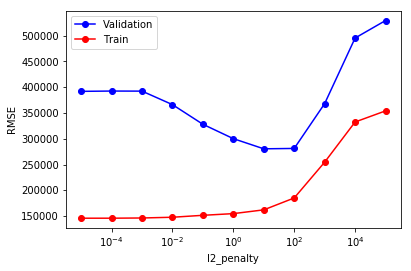

In [0]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['validation_rmse'], 
         'b-o', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['train_rmse'], 
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty')
plt.ylabel('RMSE')
plt.legend()

Next, we want to actually look at which model we think will perform best. First we define a helper function that will be used to inspect the model parameters.

In [0]:
def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(model.coef_, features))
    print(*feats, sep = "\n")

In the cell below, write code that uses the `ridge_data` `DataFrame` to select which L2 penalty we would choose based on the evaluations we did in the previous section. You should print out the following values to help you answer the next questions! 
* The best L2 penalty based on the model evaluations
* Take the best model and evaluate its error on the **test** dataset. Report the number as an RMSE.
* Call the `print_coefficients` function passing in the model itself and the features used so you can look at all of its coefficient values.

To do this in `pandas`, you'll need to use the `idxmin()` function to find the index of the smallest value in a column and the `loc` property to access that index. As an example, suppose we had a `DataFrame` named `df`:

| a | b | c |
|---|---|---|
| 1 | 2 | 3 |
| 2 | 1 | 3 |
| 3 | 2 | 1 |

If we wrote the code 
```python
index = df['b'].idxmin()
row = df.loc[index]
```

It would first find the index of the smallest value in the `b` column and then uses the `.loc` property of the `DataFrame` to access that particular row. It will return a `Series` object (basically a Python dictionary) which means you can use syntax like `row['a']` to access a particular column of that row.

In [1]:
# TODO Print information about best L2 model
index = ridge_data['validation_rmse'].idxmin()
row = ridge_data.loc[index]
print(row['model'])

#print_coefficients(row['model'], all_features)

NameError: ignored

### Q2) Based on your evaluations, which L2 penalty would you use?
<div class="alert alert-block alert-success">
<ul>
    <li>10<sup>1</sup></li>

</ul>
</div>

### Q3) For the model you chose for the Q2, what is its test RMSE?
<div class="alert alert-block alert-success">
<code>Ridge</code> model: 350668 (round to the nearest integer.)
</div>

### Q4) For the model you chose in Q2, what is the number of features that have coefficient 0?
<div class="alert alert-block alert-success">
  <ul>
    <li> 0
    </ul>
</div>

In [0]:
print(row['model'])
clf = Ridge(alpha = 10, random_state=None)
model1 = clf.fit(train[all_features], train['price'])
print(model1)
y_pred = model1.predict(test[all_features])
y_true = test['price']
MSE=mean_squared_error(y_true, y_pred)
RMSE1 = (MSE)**(1/2)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
350668.0


In [0]:

y_pred = row['model'].predict(test[all_features])
y_true = test['price']
MSE=mean_squared_error(y_true, y_pred)
RMSE1 = (MSE)**(1/2)
print(round(RMSE1))

350668.0


--- 
## LASSO Regression
In this section you will do basically the exact same analysis you did with Ridge Regression, but using LASSO Regression instead. Remember that for LASSO we choose the parameters that minimize this quality metric instead 

$$\hat{w}_{LASSO} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_1$$

where $\left\lVert w \right\rVert_1 = \sum_{j=0}^D \lVert w_j \rVert$ is the L1 norm of the parameter vector.

We will use the same set of instructions for LASSO as we did for Ridge, except for the following differences. Please refer back to the Ridge Regression instructions and your code to see how these differences fit in!

* Use the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) model. Like before, the only parameters you need to pass in are `alpha` for the L1 penalty and `random_state=0`.
* The range L1 penalties should be $[10, 10^2, ..., 10^7]$. In Python, this is `np.logspace(1, 7, num=7)`.
* The result should be stored in a `DataFrame` named `lasso_data`. All the columns should have the same name and corresponding values except the penalty column should be called `l1_penalty`.
* It is okay if your code prints some `ConvergenceWarning` warnings, these should not impact your results!.

You do not need to worry about your code being redundant for this part.

In [0]:
# TODO Implement code to evaluate LASSO Regression with various L1 penalties
l2_penalties = np.logspace(1, 7, num=7)
data = []

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
for i in range(len(l2_penalties)):
  clf = Lasso(alpha = l2_penalties[i], random_state=None)
  model1 = clf.fit(train[all_features], train['price'])
  y_pred = model1.predict(train[all_features])
  y_true = train['price']
  MSE=mean_squared_error(y_true, y_pred)
  RMSE1 = (MSE)**(1/2)
  y_pred = clf.predict(validation[all_features])
  y_true = validation['price']
  MSE2=mean_squared_error(y_true, y_pred)
  RMSE3 = (MSE2)**(1/2)
  data.append({
      'l1_penalty':l2_penalties[i],
      'model':model1,
      'train_rmse':RMSE1,
      'validation_rmse': RMSE3
  })

lasso_data = pd.DataFrame(data)
print(lasso_data)

   l1_penalty  ... validation_rmse
0        10.0  ...   335241.388585
1       100.0  ...   322816.843560
2      1000.0  ...   284368.235272
3     10000.0  ...   268444.047540
4    100000.0  ...   414751.280563
5   1000000.0  ...   533861.713077
6  10000000.0  ...   533861.713077

[7 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649508920297.8142, tolerance: 1912867203.4052832
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 959552311817.7407, tolerance: 1912867203.4052832
  positive)


Here is a sanity check like before.

In [0]:
assert type(lasso_data) == pd.DataFrame
assert len(lasso_data) == 7

for col in ['l1_penalty', 'model', 'train_rmse', 'validation_rmse']:
    assert col in lasso_data.columns, f'Missing column {col}'

Like before, let's look at how the L1 penalty affects the performance.

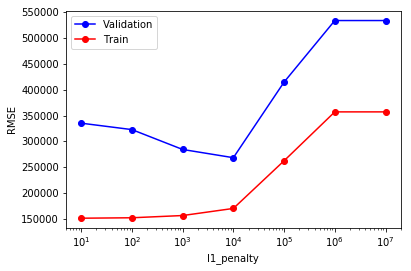

In [0]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['validation_rmse'],
         'b-o', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty')
plt.ylabel('RMSE')
plt.legend()

Like before, in the cell below, write code that uses the `lasso_data` `DataFrame` to select which L1 penalty we would choose based on the evaluations we did in the previous section. You should print out the following values to help you answer the next questions! 
* The best L1 penalty based on the model evaluations
* Take the best model and evaluate it on the test dataset and report its RMSE
* Call the `print_coefficients` function passing in the model itself and the features used so you can look at all of its coefficient values. Note some of the values are `-0.0` which is the same as `0.0` for our purposes.

In [0]:
# TODO Print information about best L1 model
index = lasso_data['validation_rmse'].idxmin()
row1 = lasso_data.loc[index]
print(row1)

print_coefficients(row1['model'], all_features) 
#coefficient with 0 means that it is not selected

l1_penalty                                                     10000
model              Lasso(alpha=10000.0, copy_X=True, fit_intercep...
train_rmse                                                    170239
validation_rmse                                               268444
Name: 3, dtype: object
(-0.0, 'bedrooms')
(-0.0, 'bedrooms_square')
(-19129.61338317553, 'bedrooms_sqrt')
(-0.0, 'bathrooms')
(113626.05363381631, 'bathrooms_square')
(-0.0, 'bathrooms_sqrt')
(0.0, 'sqft_living')
(0.0, 'sqft_living_square')
(0.0, 'sqft_living_sqrt')
(0.0, 'sqft_lot')
(8103.923178885526, 'sqft_lot_square')
(0.0, 'sqft_lot_sqrt')
(-0.0, 'floors')
(-0.0, 'floors_square')
(-12044.473362529388, 'floors_sqrt')
(172128.40168391602, 'waterfront')
(6.7148219537619715e-09, 'waterfront_square')
(1.2900714608572473e-11, 'waterfront_sqrt')
(0.0, 'view')
(0.0, 'view_square')
(-0.0, 'view_sqrt')
(0.0, 'condition')
(0.0, 'condition_square')
(0.0, 'condition_sqrt')
(0.0, 'grade')
(155737.85002833238, 'grade_square'

### Q5) Based on your evaluations, which L1 penalty would you use?
<div class="alert alert-block alert-success">
<b>Gradescope:</b> Enter one of these options on Gradescope.
<ul>
    <li>10<sup>4</sup></li>

</ul>
</div>

### Q6) For the model you chose for Q5, what is its test RMSE?
<div class="alert alert-block alert-success">
<b>Gradescope:</b> Type in the test error for the best <code>Lasso</code> model. You should round the RMSE to the nearest integer. 
</div>

In [0]:

y_pred = row1['model'].predict(test[all_features])
y_true = test['price']
MSE=mean_squared_error(y_true, y_pred)
RMSE1 = (MSE)**(1/2)
print(round(RMSE1))
#print(y_pred)
#print(y_true)

341484.0
[-179998.98486932  -45941.69253998 -157737.45863845  -49805.92062126
 -244997.5103743  -110226.44023621 -158738.34985459  162474.03375149
    4886.2258341  -214040.01701888  682829.45108787  -27025.45496424
 1734154.7922995   118192.27448448   -8582.83409131 -207610.54867926
  -25930.04650478  112249.68475117  390766.77094486 -127228.76769824
 -103536.09526216 -231960.30028643  106162.84956864 -221854.36755971
  -82548.38058557  160485.71503325  155390.30493951  -23960.59906492
  357911.97140395 -199556.09167964  -10034.06612564 -166213.53257467
   38726.44425524  156220.33300691  346622.95900624 -145026.1399485
 -255376.45538633 -168588.66351065  492458.63316535  975892.79288095
  -86629.39659828  714995.76427652 -211172.4770246   339048.93197145]
15209   -3.146196e+04
8439    -1.689620e+05
7229    -1.214620e+05
20670   -4.446196e+04
15463   -3.114620e+05
12080   -1.364620e+05
3880    -1.894620e+05
8999     6.038042e+03
6631    -2.064620e+05
20282   -3.304620e+05
6930     4.3

### Q7) Features with no coefficient of 0 will be selected for Lasso model
<div class="alert alert-block alert-success" style="overflow: auto">


### Q8) Based on our experiments, which model would we expect to perform best in the future?
<div class="alert alert-block alert-success">

<ul>
    <li>Lasso</li>

</ul>
</div>
